In [406]:
# basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, plot_confusion_matrix, plot_roc_curve, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# statsmodels
import statsmodels.api as sm

# helpers
from boruta import BorutaPy

# notebbok style
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

### Read in data, encode target variable

Target: {0 : benign; 1 : malignant / cancerous}

In [5]:
data = pd.read_csv("breast-cancer-wisconsin.data", header = None, names = ['id', 'clump_thickness', 'cell_size_uniformity', 'cell_shape_uniformity', 'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class'])
data['class'] = data['class'].map({2: 'benign', 4: 'malignant'})
data.head()

,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,benign
1,1002945,5,4,4,5,7,10,3,2,1,benign
2,1015425,3,1,1,1,2,2,3,1,1,benign
3,1016277,6,8,8,1,3,4,3,7,1,benign
4,1017023,4,1,1,3,2,1,3,1,1,benign


In [6]:
encoder = LabelEncoder()
encoder.fit(data['class'])

data['class'] = encoder.transform(data['class'])

data.rename(columns = {'class': 'malignant'}, inplace = True)

data.head()

,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


### Explore dataset

#### Target variable

In [7]:
target_freq = pd.concat([data['malignant'].value_counts(), data['malignant'].value_counts(normalize=True) * 100], axis = 1, keys = ['#', '%'])
target_freq

,#,%
0,458,65.522175
1,241,34.477825


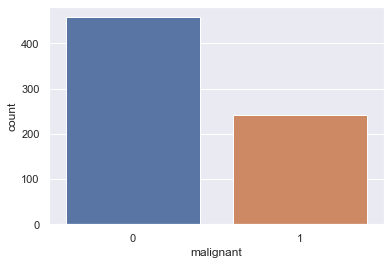

In [8]:
sns.countplot(x = "malignant", data = data)

#### X variables

In [9]:
data.dtypes

id                              int64
clump_thickness                 int64
cell_size_uniformity            int64
cell_shape_uniformity           int64
marginal_adhesion               int64
single_epithelial_cell_size     int64
bare_nuclei                    object
bland_chromatin                 int64
normal_nucleoli                 int64
mitoses                         int64
malignant                       int32
dtype: object

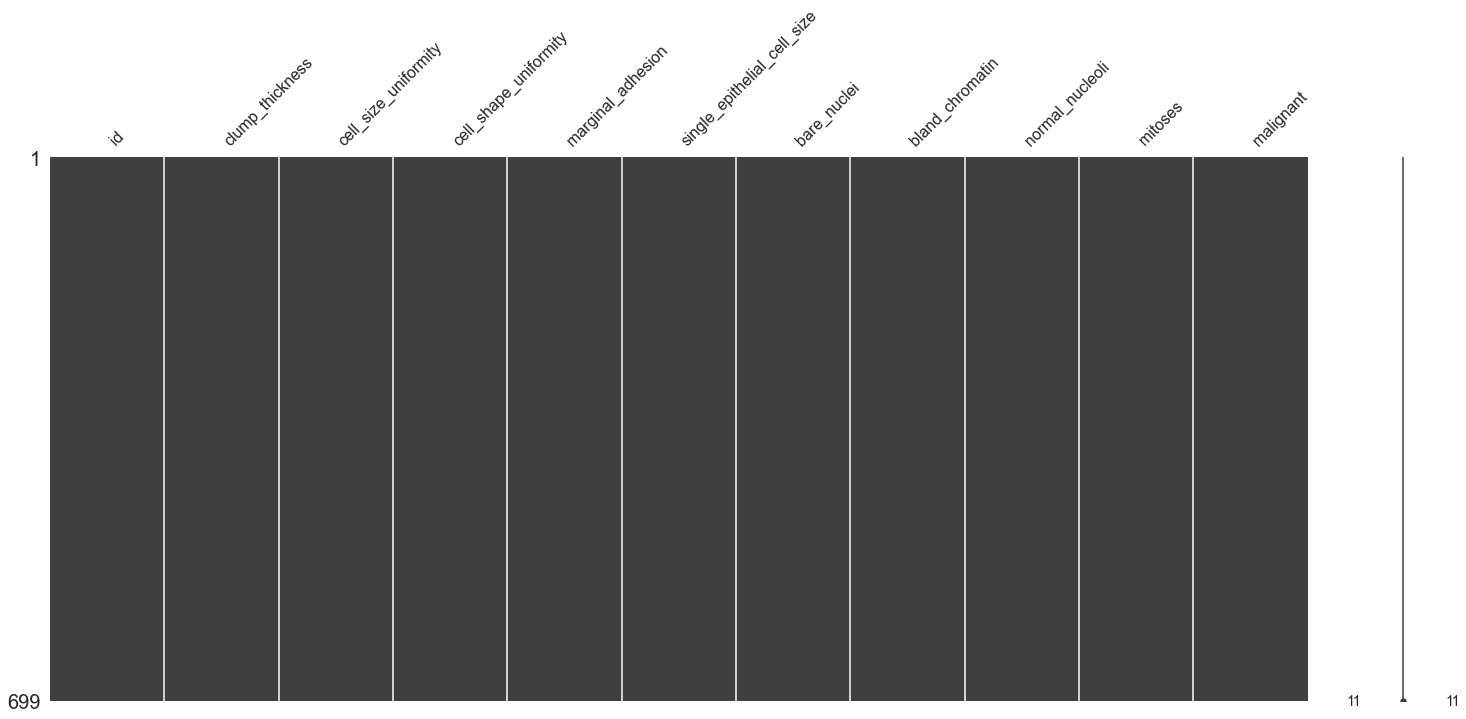

In [10]:
msno.matrix(data)

In [11]:
data.describe(include = ['O'])

,bare_nuclei
count,699
unique,11
top,1
freq,402


In [12]:
data['bare_nuclei'].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

In [13]:
data = data[data['bare_nuclei'] != '?']
data['bare_nuclei'] = data['bare_nuclei'].astype('int')

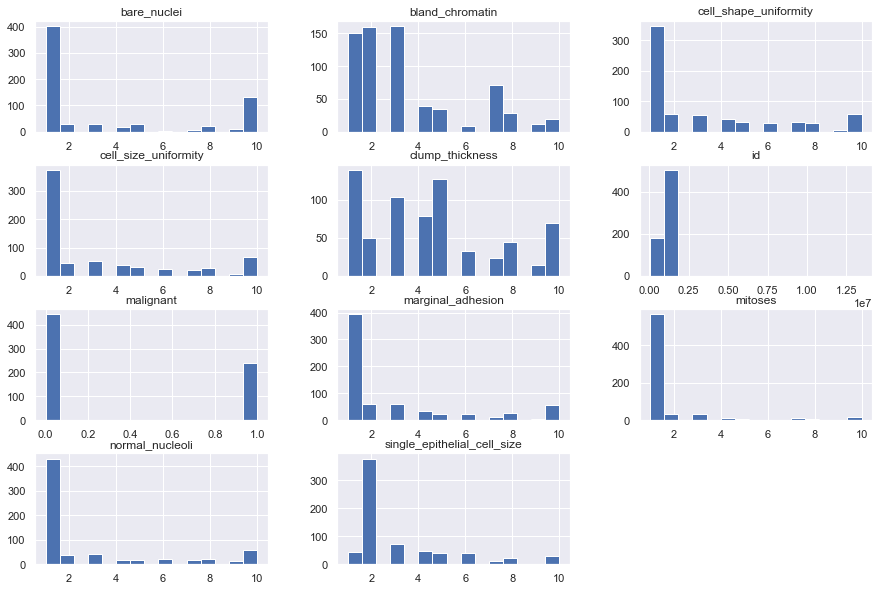

In [14]:
data.hist(bins = 15, figsize = (15, 10))
plt.show()

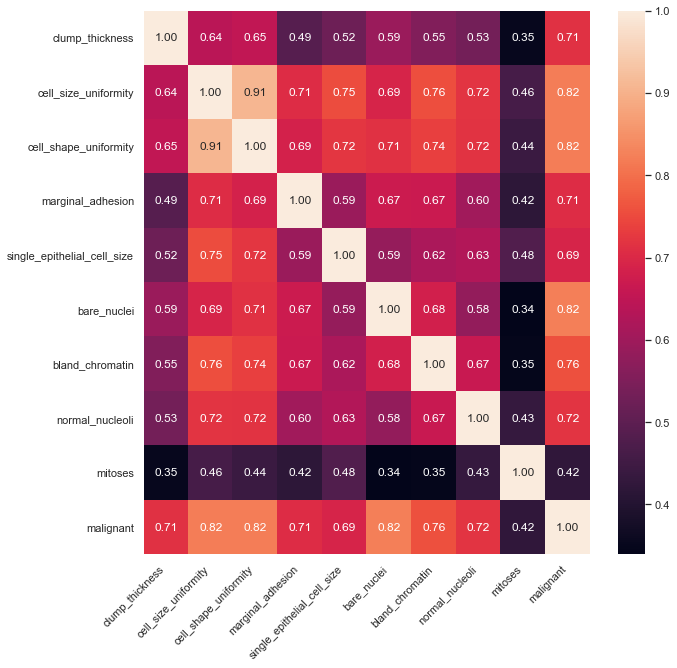

In [15]:
correlations = data.drop('id', 1).corr()

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(correlations, annot = True, fmt = ".2f")

ax.set_xticklabels(data.drop('id', 1).columns, rotation=45, horizontalalignment='right')
ax.set_yticklabels(data.drop('id', 1).columns)

plt.show()

cell_size_uniformity & cell_shape_uniformity correlate high (+0.9). Which one to drop and keep? Transform them into 1 maybe? i'll run Boruta to see if either one is insignificant.

In [16]:
forest = RandomForestClassifier(max_depth = 5)
boruta = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100)
boruta.fit(np.array(data.drop(['id', 'malignant'], 1)), np.array(data['malignant']))

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=84,
                                          random_state=RandomState(MT19937) at 0x1FBD60F1640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1FBD60F1640)

In [17]:
to_keep = data.drop(['id', 'malignant'], 1).columns[boruta.support_].to_list()

print('Boruta suggests keeping', len(to_keep), 'features out of 9:', to_keep)

Boruta suggests keeping 9 features out of 9: ['clump_thickness', 'cell_size_uniformity', 'cell_shape_uniformity', 'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses']


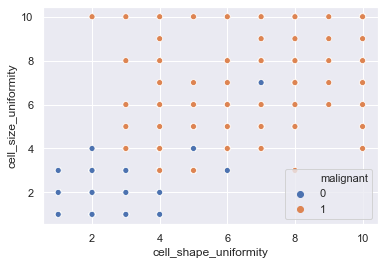

In [18]:
sns.scatterplot(data['cell_shape_uniformity'], data['cell_size_uniformity'], hue = data['malignant'])
plt.show()

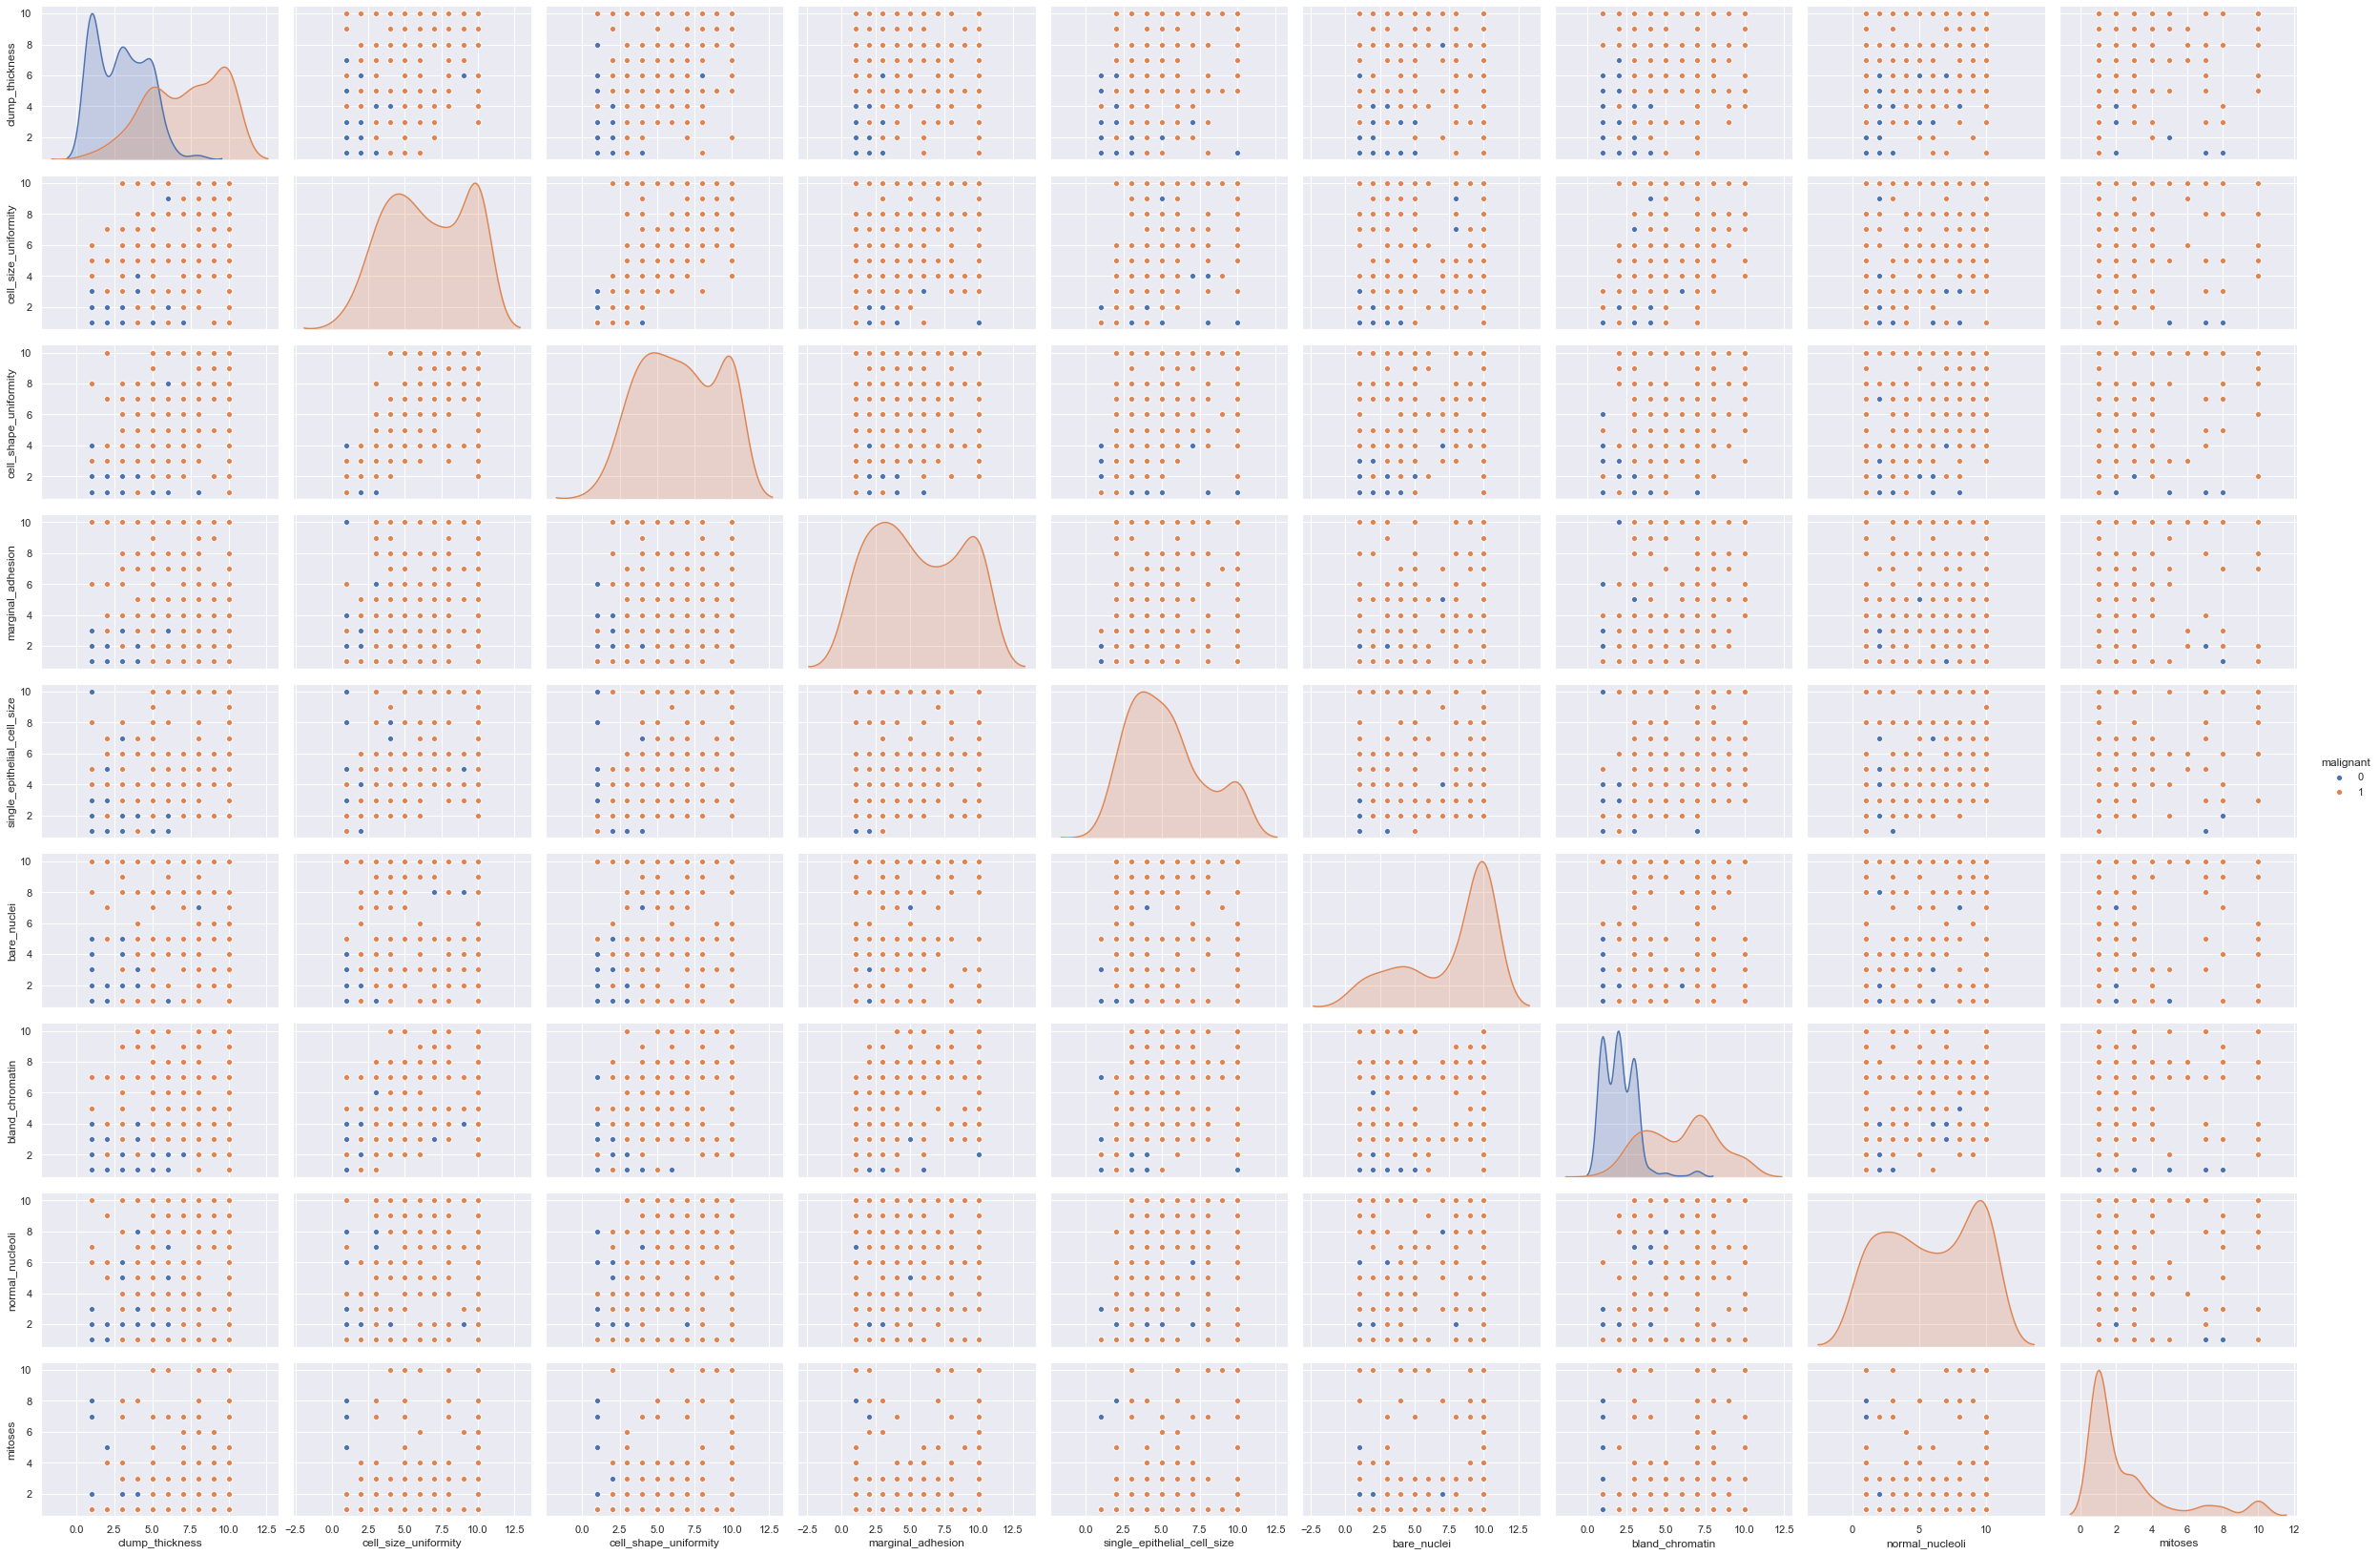

In [19]:
sns.pairplot(data.drop('id', 1), hue = 'malignant', aspect=1.5)
plt.show()

Dropping cell_size for now

In [20]:
data.drop('cell_size_uniformity', 1, inplace = True)

### Preprocess data (scale, split)

In [21]:
X = data.copy().drop(['id', 'malignant'], 1)
y = data['malignant']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 20202020)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(512, 8) (171, 8) (512,) (171,)


In [23]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Apply logistic regression

In [24]:
logit = LogisticRegression(penalty = 'none')
logit.fit(X_train_scaled, y_train)

LogisticRegression(penalty='none')

In [25]:
pred_prob = pd.DataFrame(logit.predict_proba(X_test_scaled), columns = ['prediction_for_class_0', 'prediction_for_class_1'])
pred_class = pd.DataFrame(logit.predict(X_test_scaled), columns = ['predicted_class'])
act_class = pd.DataFrame(np.array(y_test), columns = ['actual_class'])

pd.concat([pred_prob, pred_class, act_class], 1).head()

,prediction_for_class_0,prediction_for_class_1,predicted_class,actual_class
0,0.023413,0.976587,1,1
1,0.997873,0.002127,0,0
2,0.998840,0.001160,0,0
3,0.978933,0.021067,0,0
4,0.982435,0.017565,0,0


In [26]:
print('Accuracy on test set: ', round(accuracy_score(y_test, logit.predict(X_test_scaled)), 3))
print('AUC on test set: ', round(roc_auc_score(y_test, logit.predict_proba(X_test_scaled)[:,1]), 3))
print('\n')
print(classification_report(y_test, logit.predict(X_test_scaled)))

Accuracy on test set:  0.965
AUC on test set:  0.996


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       111
           1       0.95      0.95      0.95        60

    accuracy                           0.96       171
   macro avg       0.96      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



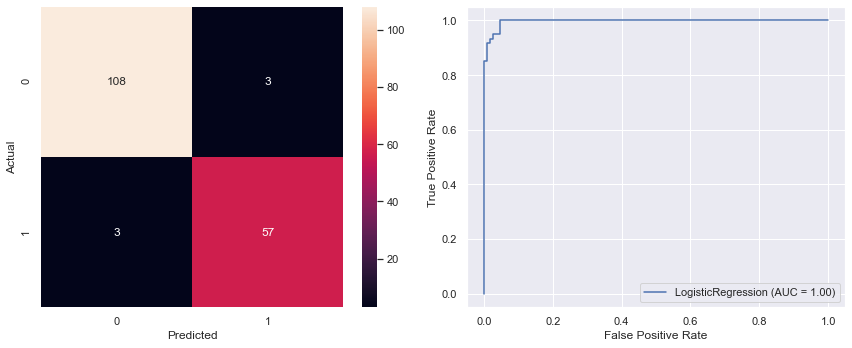

In [27]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

confusion_matrix = pd.crosstab(y_test, logit.predict(X_test_scaled), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0])

plot_roc_curve(logit, X_test_scaled, y_test, ax = axs[1])

fig.tight_layout()
plt.show()

In [28]:
logit_coeff = pd.concat([pd.DataFrame(X_train.columns, columns = ['Feature']), 
           pd.DataFrame(np.transpose(logit.coef_), columns = ['Coefficient'])], 
          axis = 1)

logit_coeff

,Feature,Coefficient
0,clump_thickness,1.537763
1,cell_shape_uniformity,0.939045
2,marginal_adhesion,0.511741
3,single_epithelial_cell_size,0.717133
4,bare_nuclei,1.375577
5,bland_chromatin,1.213184
6,normal_nucleoli,0.434297
7,mitoses,0.963679


Coefficients are usually great, but in case of logit we need mfx (marginal effects). Let's re-apply the model via the statsmodels API and extract the marginal effects from there

In [29]:
X_train_scaled_for_sm = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_train_scaled_for_sm = sm.add_constant(X_train_scaled_for_sm)

y_train.reset_index(drop = True, inplace = True)

sm_model = sm.Logit(y_train, X_train_scaled_for_sm).fit()

sm_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.074235
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-1.1228,0.387,-2.899,0.004,-1.882,-0.364
clump_thickness,1.5378,0.460,3.342,0.001,0.636,2.440
cell_shape_uniformity,0.9391,0.660,1.422,0.155,-0.355,2.233
marginal_adhesion,0.5117,0.408,1.255,0.209,-0.287,1.311
single_epithelial_cell_size,0.7171,0.459,1.563,0.118,-0.182,1.616
bare_nuclei,1.3756,0.419,3.281,0.001,0.554,2.197
bland_chromatin,1.2132,0.508,2.389,0.017,0.218,2.209
normal_nucleoli,0.4342,0.392,1.106,0.269,-0.335,1.203
mitoses,0.9637,0.711,1.355,0.176,-0.431,2.358


In [30]:
sm_model.get_margeff().summary().tables[1]

,dy/dx,std err,z,P>|z|,[0.025,0.975]
clump_thickness,0.0292,0.009,3.207,0.001,0.011,0.047
cell_shape_uniformity,0.0178,0.012,1.444,0.149,-0.006,0.042
marginal_adhesion,0.0097,0.008,1.233,0.218,-0.006,0.025
single_epithelial_cell_size,0.0136,0.009,1.578,0.115,-0.003,0.031
bare_nuclei,0.0261,0.008,3.379,0.001,0.011,0.041
bland_chromatin,0.0230,0.010,2.348,0.019,0.004,0.042
normal_nucleoli,0.0082,0.007,1.106,0.269,-0.006,0.023
mitoses,0.0183,0.014,1.351,0.177,-0.008,0.045


Show features, coefficients and marginal effects in one table, enhance them with odds prob

In [31]:
marg_eff = pd.DataFrame(sm_model.get_margeff().summary().tables[1])[[0, 1]]
marg_eff.rename(columns = {0 : 'Feature', 1 : 'MFX'}, inplace = True)
marg_eff = marg_eff.iloc[1:]

In [32]:
marg_eff.reset_index(drop = True, inplace = True)
logit_coeff.reset_index(drop = True, inplace = True)

coeff_mfx = logit_coeff.join(marg_eff, rsuffix = 'a')
coeff_mfx.drop('Featurea', 1, inplace = True)
coeff_mfx['MFX'] = coeff_mfx['MFX'].astype('str').astype('float')

coeff_mfx.sort_values('MFX', ascending = False)

,Feature,Coefficient,MFX
0,clump_thickness,1.537763,0.0292
4,bare_nuclei,1.375577,0.0261
5,bland_chromatin,1.213184,0.0230
7,mitoses,0.963679,0.0183
1,cell_shape_uniformity,0.939045,0.0178
3,single_epithelial_cell_size,0.717133,0.0136
2,marginal_adhesion,0.511741,0.0097
6,normal_nucleoli,0.434297,0.0082


#### Try some visuals

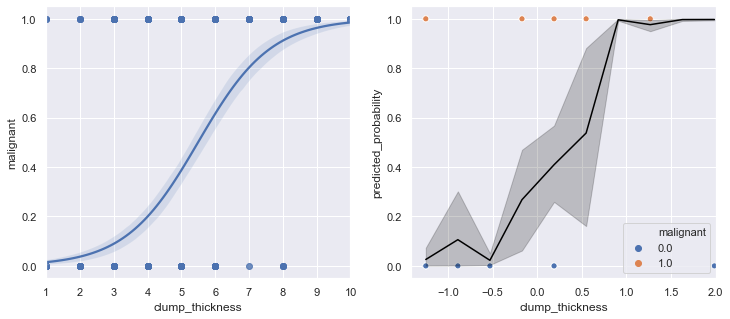

In [33]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

sns.regplot(x = 'clump_thickness', y = 'malignant', data = data, logistic = True, ax = axs[0])

test_data = pd.concat([pd.DataFrame(X_test_scaled, columns = X_test.columns),
                       pd.DataFrame(logit.predict_proba(X_test_scaled)[:,1], columns = ['predicted_probability']),
                       pd.DataFrame(y_test)], 1)

sns.scatterplot(x = 'clump_thickness', y = 'malignant', hue = 'malignant', data = test_data, ax = axs[1])
sns.lineplot(x = 'clump_thickness', y = 'predicted_probability', data = test_data, c = 'black', ax = axs[1]).set(xlim=(None, 2))
plt.show()

##### Apply PCA to be able to visualize all features' relationship to class outcomes

In [34]:
pca = PCA(random_state = 20202020)
pca.fit(X_test_scaled)

comp = pd.DataFrame(pca.components_, columns = X_test.columns)
exp_var = pd.DataFrame(pca.explained_variance_ratio_ * 100, columns = ['Explained variance %'])

pca_results = pd.concat([exp_var, comp], 1)
pca_results

,Explained variance %,clump_thickness,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
0,65.767771,0.368064,0.394868,0.347541,0.328370,0.376070,0.394406,0.392783,0.169512
1,7.596942,0.508727,-0.049792,0.258625,-0.313259,0.430201,-0.152078,-0.581672,-0.164794
2,6.110469,0.681820,-0.003881,-0.486648,0.226975,-0.349773,-0.142457,-0.053561,0.318211
3,5.881721,-0.170215,0.190908,0.271716,-0.337066,-0.099620,-0.112393,-0.144812,0.838815
4,5.407563,-0.059953,0.101292,0.478781,0.542909,-0.473463,0.048893,-0.474189,-0.103692
5,3.648745,-0.228722,-0.029461,-0.436006,0.175973,0.289332,0.602711,-0.487314,0.203229
6,3.047863,0.223469,-0.074228,0.122655,-0.517017,-0.472785,0.643620,0.057953,-0.145152
7,2.538926,-0.077640,0.887976,-0.259415,-0.189439,-0.099133,-0.092151,-0.133613,-0.257130


In [39]:
pca_applied = pd.DataFrame(pca.transform(X_test_scaled))
pca_applied = pca_applied[[0, 1]].copy()
pca_applied.columns = ['PCA_1', 'PCA_2']

y_test.reset_index(drop = True, inplace = True)

test_data_with_PCA = pd.concat([pd.DataFrame(X_test_scaled, columns = X_test.columns), pca_applied, y_test], 1)

test_data_with_PCA.head()

,clump_thickness,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,PCA_1,PCA_2,malignant
0,-1.247161,1.593033,1.108770,0.777568,1.232199,1.445173,2.409163,-0.357001,2.743510,-1.661158,1
1,-0.528886,-0.741158,-0.629412,-0.552437,-0.703882,-1.011701,-0.600168,-0.357001,-1.833759,0.078747,0
2,-1.247161,-0.741158,-0.629412,-0.552437,-0.703882,-0.602222,-0.600168,-0.357001,-1.936629,-0.348931,0
3,0.189389,-0.741158,1.108770,-0.109102,-0.703882,-1.011701,-0.600168,-0.357001,-0.819721,0.754810,0
4,-0.528886,-0.407702,-0.281775,-0.552437,-0.703882,0.216736,-0.265798,-0.357001,-0.965433,-0.229262,0


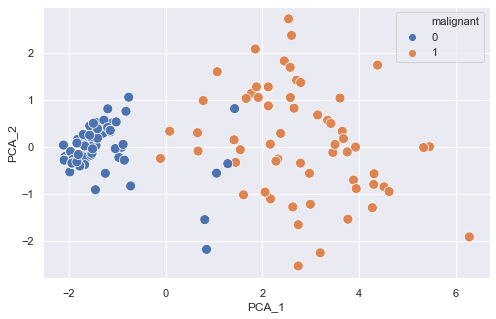

In [40]:
plt.figure(figsize = (8, 5))
sns.scatterplot('PCA_1', 'PCA_2', data = test_data_with_PCA, hue = 'malignant', s = 100)
plt.show()

The 1st PCA contains all features with a positive and similar weight. Benign cells are all closer to the negative end of the x axis, meaning on average the smallest values in any category are a good sign, as larger values tend to go together with the malignant class.

Positive coefficients and MFXs (all are > 0) of the logistic regression prove the above idea.

### Apply a RandomForest and compare variable importances with logit's marginal effects list

In [41]:
parameters = {'min_samples_split': [5], # 3, 5, 7
              'max_depth': [7], # 5, 7, 9
              'max_features' : [2]} # 2, 3, 4

classifier = RandomForestClassifier(random_state = 20202020, n_estimators = 150)

tuner = GridSearchCV(classifier, parameters, verbose = 0, cv = 5, scoring = 'roc_auc')

tuner.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=150,
                                              random_state=20202020),
             param_grid={'max_depth': [7], 'max_features': [2],
                         'min_samples_split': [5]},
             scoring='roc_auc')

In [42]:
tuner.best_params_

{'max_depth': 7, 'max_features': 2, 'min_samples_split': 5}

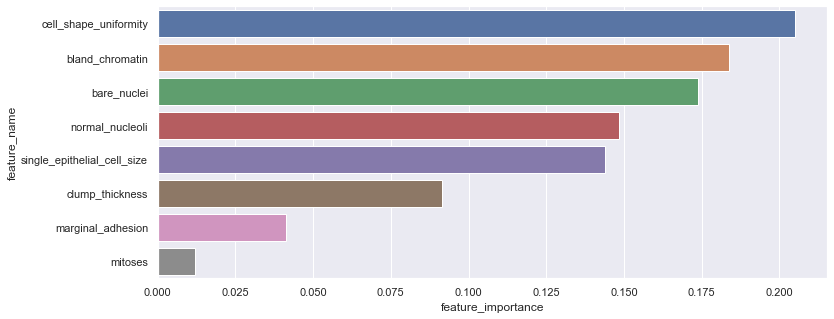

In [43]:
feature_importances = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(tuner.best_estimator_.feature_importances_)], 1)
feature_importances.columns = ['feature_name', 'feature_importance']
feature_importances = feature_importances.sort_values('feature_importance', ascending = False)

plt.figure(figsize = (12,5))
sns.barplot(y = feature_importances['feature_name'], x = feature_importances['feature_importance'])
plt.show()

In [44]:
print('Accuracy on test set: ', round(accuracy_score(y_test, tuner.best_estimator_.predict(X_test_scaled)), 3))
print('AUC on test set: ', round(roc_auc_score(y_test, tuner.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3))
print('\n')
print(classification_report(y_test, tuner.best_estimator_.predict(X_test_scaled)))

Accuracy on test set:  0.971
AUC on test set:  0.995


              precision    recall  f1-score   support

           0       0.99      0.96      0.98       111
           1       0.94      0.98      0.96        60

    accuracy                           0.97       171
   macro avg       0.96      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



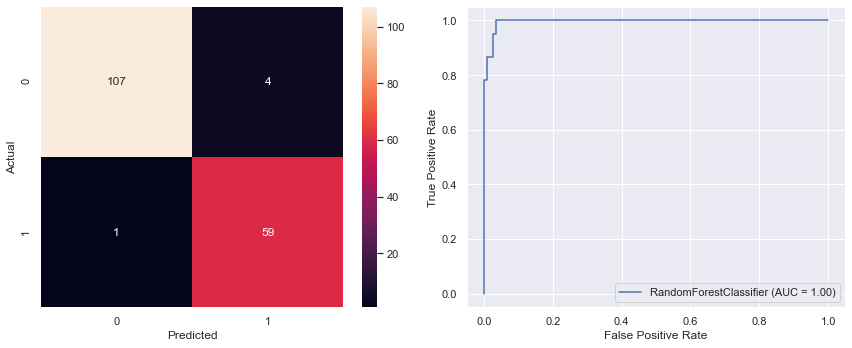

In [45]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

confusion_matrix = pd.crosstab(y_test, tuner.best_estimator_.predict(X_test_scaled), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0])

plot_roc_curve(tuner.best_estimator_, X_test_scaled, y_test, ax = axs[1])

fig.tight_layout()
plt.show()

### Apply a Gradient Boosting Machine

In [243]:
parameters = {'min_samples_split': [3, 5, 7, 9],
              'max_depth': [5, 7, 9],
              'max_features' : [2, 3, 4, 5], 
              'subsample' : [0.75, 1],
              'learning_rate' : [0.01]}

classifier = GradientBoostingClassifier(random_state = 20202020, n_estimators = 150)

tuner_gbm = GridSearchCV(classifier, parameters, verbose = 0, cv = 5, scoring = 'roc_auc')

tuner_gbm.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=150,
                                                  random_state=20202020),
             param_grid={'learning_rate': [0.01, 0.05], 'max_depth': [5, 7, 9],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_split': [3, 5, 7, 9],
                         'subsample': [0.75, 1]},
             scoring='roc_auc')

In [244]:
tuner_gbm.best_params_

{'learning_rate': 0.01,
 'max_depth': 7,
 'max_features': 2,
 'min_samples_split': 7,
 'subsample': 0.75}

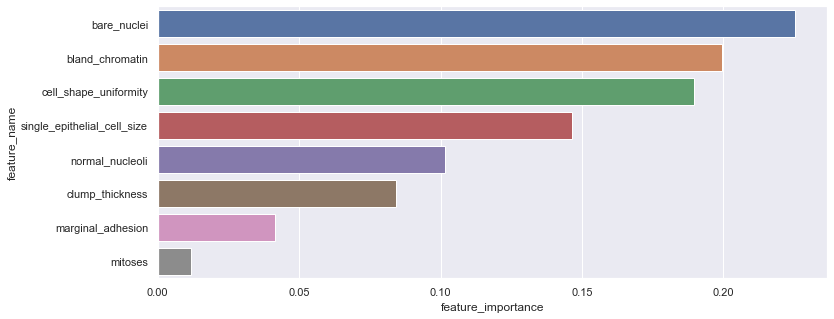

In [245]:
feature_importances = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(tuner_gbm.best_estimator_.feature_importances_)], 1)
feature_importances.columns = ['feature_name', 'feature_importance']
feature_importances = feature_importances.sort_values('feature_importance', ascending = False)

plt.figure(figsize = (12,5))
sns.barplot(y = feature_importances['feature_name'], x = feature_importances['feature_importance'])
plt.show()

In [246]:
print('Accuracy on test set: ', round(accuracy_score(y_test, tuner_gbm.best_estimator_.predict(X_test_scaled)), 3))
print('AUC on test set: ', round(roc_auc_score(y_test, tuner_gbm.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3))
print('\n')
print(classification_report(y_test, tuner_gbm.best_estimator_.predict(X_test_scaled)))

Accuracy on test set:  0.959
AUC on test set:  0.995


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       111
           1       0.93      0.95      0.94        60

    accuracy                           0.96       171
   macro avg       0.95      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



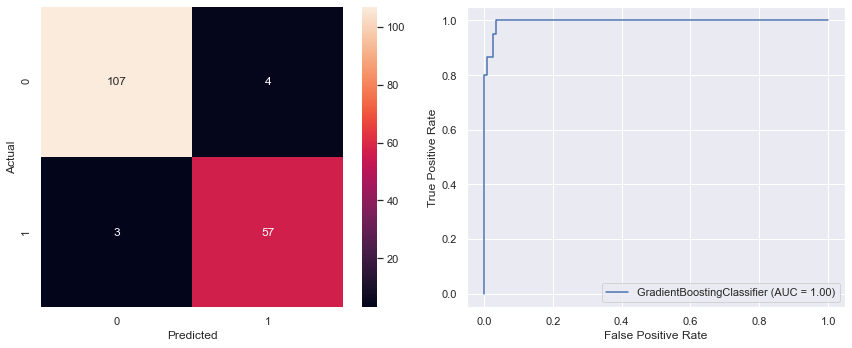

In [247]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

confusion_matrix = pd.crosstab(y_test, tuner_gbm.best_estimator_.predict(X_test_scaled), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0])

plot_roc_curve(tuner_gbm.best_estimator_, X_test_scaled, y_test, ax = axs[1])

fig.tight_layout()
plt.show()

### Apply Support Vector Classifier

In [321]:
parameters = {'C': [1], # 0.5, 1, 1.5, 2, 5, 10
              'kernel': ['poly'], # 'linear', 'poly', 'rbf'
              'degree' : [5], # 2, 3, 4, 5, 6, 7
              'gamma' : ['scale']} # 'scale', 'auto', 0.1, 0.01, 0.05, 0.5

classifier = SVC(random_state = 20202020, probability = True)

tuner_svc = GridSearchCV(classifier, parameters, verbose = 0, cv = 5, scoring = 'roc_auc')

tuner_svc.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=20202020),
             param_grid={'C': [1], 'degree': [5], 'gamma': ['scale'],
                         'kernel': ['poly']},
             scoring='roc_auc')

In [322]:
tuner_svc.best_params_

{'C': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}

In [323]:
print('Accuracy on test set: ', round(accuracy_score(y_test, tuner_svc.best_estimator_.predict(X_test_scaled)), 3))
print('AUC on test set: ', round(roc_auc_score(y_test, tuner_svc.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3))
print('\n')
print(classification_report(y_test, tuner_svc.best_estimator_.predict(X_test_scaled)))

Accuracy on test set:  0.942
AUC on test set:  0.997


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       111
           1       1.00      0.83      0.91        60

    accuracy                           0.94       171
   macro avg       0.96      0.92      0.93       171
weighted avg       0.95      0.94      0.94       171



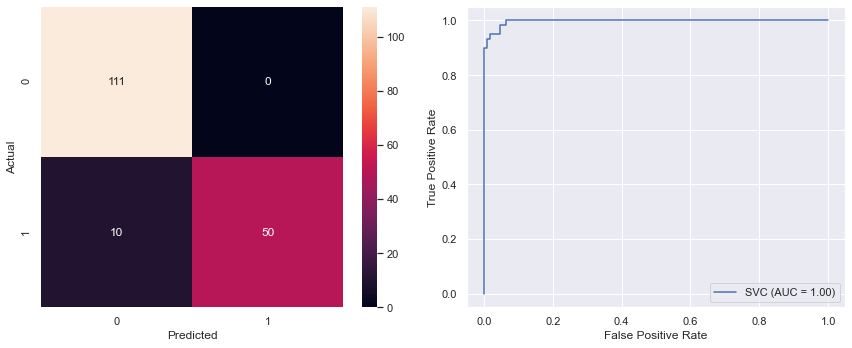

In [324]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

confusion_matrix = pd.crosstab(y_test, tuner_svc.best_estimator_.predict(X_test_scaled), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0])

plot_roc_curve(tuner_svc.best_estimator_, X_test_scaled, y_test, ax = axs[1])

fig.tight_layout()
plt.show()

### Apply KNN Classifier

In [331]:
parameters = {'n_neighbors': [3, 5, 7, 9, 11], 
              'weights': ['uniform', 'distance'], 
              'p' : [1, 2]} 

classifier = KNeighborsClassifier()

tuner_knn = GridSearchCV(classifier, parameters, verbose = 0, cv = 5, scoring = 'roc_auc')

tuner_knn.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [333]:
tuner_knn.best_params_

{'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}

In [334]:
print('Accuracy on test set: ', round(accuracy_score(y_test, tuner_knn.best_estimator_.predict(X_test_scaled)), 3))
print('AUC on test set: ', round(roc_auc_score(y_test, tuner_knn.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3))
print('\n')
print(classification_report(y_test, tuner_knn.best_estimator_.predict(X_test_scaled)))

Accuracy on test set:  0.953
AUC on test set:  0.994


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       111
           1       0.93      0.93      0.93        60

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171



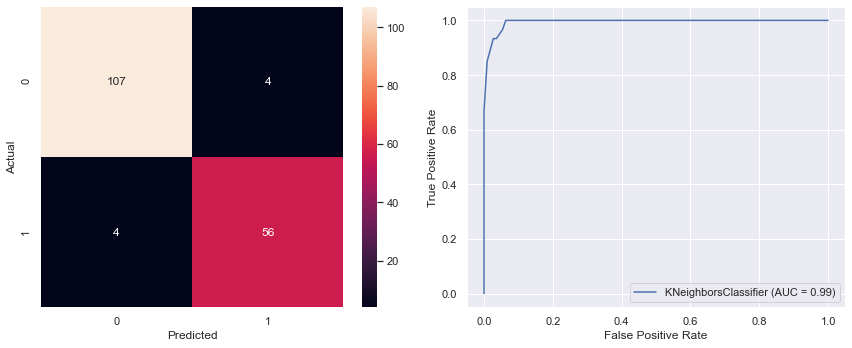

In [335]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

confusion_matrix = pd.crosstab(y_test, tuner_knn.best_estimator_.predict(X_test_scaled), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0])

plot_roc_curve(tuner_knn.best_estimator_, X_test_scaled, y_test, ax = axs[1])

fig.tight_layout()
plt.show()

### Apply RadiusNN Classifier

In [348]:
parameters = {'radius': [7, 8, 9, 10, 11], 
              'weights': ['uniform', 'distance'], 
              'p' : [1, 2]} 

classifier = RadiusNeighborsClassifier()

tuner_rnn = GridSearchCV(classifier, parameters, verbose = 0, cv = 5, scoring = 'roc_auc')

tuner_rnn.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5, estimator=RadiusNeighborsClassifier(),
             param_grid={'p': [1, 2], 'radius': [7, 8, 9, 10, 11, 12],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [349]:
tuner_rnn.best_params_

{'p': 1, 'radius': 9, 'weights': 'distance'}

In [350]:
print('Accuracy on test set: ', round(accuracy_score(y_test, tuner_rnn.best_estimator_.predict(X_test_scaled)), 3))
print('AUC on test set: ', round(roc_auc_score(y_test, tuner_rnn.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3))
print('\n')
print(classification_report(y_test, tuner_rnn.best_estimator_.predict(X_test_scaled)))

Accuracy on test set:  0.93
AUC on test set:  0.996


              precision    recall  f1-score   support

           0       0.90      1.00      0.95       111
           1       1.00      0.80      0.89        60

    accuracy                           0.93       171
   macro avg       0.95      0.90      0.92       171
weighted avg       0.94      0.93      0.93       171



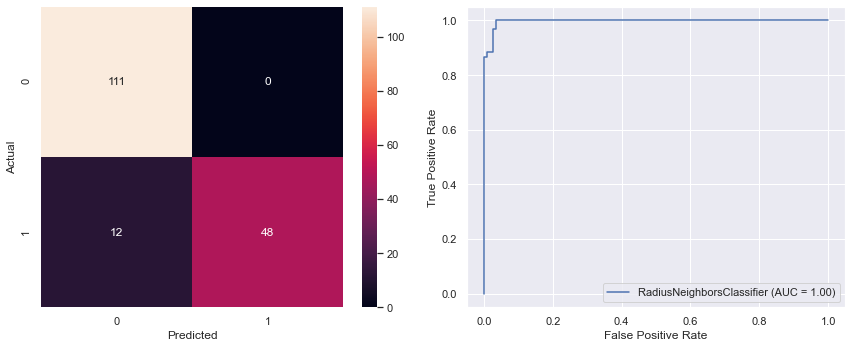

In [351]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

confusion_matrix = pd.crosstab(y_test, tuner_rnn.best_estimator_.predict(X_test_scaled), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0])

plot_roc_curve(tuner_rnn.best_estimator_, X_test_scaled, y_test, ax = axs[1])

fig.tight_layout()
plt.show()

### Apply AdaBoost Classifier

In [390]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.005],
              'n_estimators': [150, 200, 250],
              'base_estimator' : [DecisionTreeClassifier(), 
                                  SVC(kernel = 'rbf'), 
                                  SVC(kernel = 'poly', degree = 5),
                                  LogisticRegression(penalty = 'none'), 
                                  LogisticRegression(), 
                                  KNeighborsClassifier(),
                                  RadiusNeighborsClassifier()]}

classifier = AdaBoostClassifier(random_state = 20202020)

tuner_ada = GridSearchCV(classifier, parameters, verbose = 0, cv = 5, scoring = 'roc_auc')

tuner_ada.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=20202020),
             param_grid={'base_estimator': [DecisionTreeClassifier(), SVC(),
                                            SVC(degree=5, kernel='poly'),
                                            LogisticRegression(penalty='none'),
                                            LogisticRegression(),
                                            KNeighborsClassifier(),
                                            RadiusNeighborsClassifier()],
                         'learning_rate': [0.01, 0.05, 0.1, 0.005],
                         'n_estimators': [150, 200, 250]},
             scoring='roc_auc')

In [392]:
tuner_ada.best_params_

{'base_estimator': LogisticRegression(),
 'learning_rate': 0.01,
 'n_estimators': 150}

In [384]:
#feature_importances = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(tuner_ada.best_estimator_.feature_importances_)], 1)
#feature_importances.columns = ['feature_name', 'feature_importance']
#feature_importances = feature_importances.sort_values('feature_importance', ascending = False)

#plt.figure(figsize = (12,5))
#sns.barplot(y = feature_importances['feature_name'], x = feature_importances['feature_importance'])
#plt.show()

In [393]:
print('Accuracy on test set: ', round(accuracy_score(y_test, tuner_ada.best_estimator_.predict(X_test_scaled)), 3))
print('AUC on test set: ', round(roc_auc_score(y_test, tuner_ada.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3))
print('\n')
print(classification_report(y_test, tuner_ada.best_estimator_.predict(X_test_scaled)))

Accuracy on test set:  0.959
AUC on test set:  0.996


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       111
           1       0.96      0.92      0.94        60

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.95       171
weighted avg       0.96      0.96      0.96       171



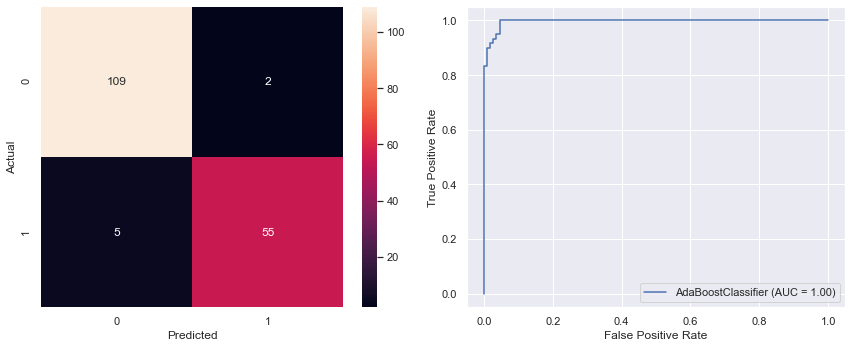

In [394]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

confusion_matrix = pd.crosstab(y_test, tuner_ada.best_estimator_.predict(X_test_scaled), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0])

plot_roc_curve(tuner_ada.best_estimator_, X_test_scaled, y_test, ax = axs[1])

fig.tight_layout()
plt.show()

### Apply DecisionTree Classifier

In [396]:
parameters = {'min_samples_leaf': [7, 9, 11, 13, 15],
              'min_samples_split' : [7, 9, 11],
              'max_depth': [3, 4, 5],
              'max_features' : [2, 3, 4, 5, 6]}

classifier = DecisionTreeClassifier(random_state = 20202020)

tuner_dtc = GridSearchCV(classifier, parameters, verbose = 0, cv = 5, scoring = 'accuracy')

tuner_dtc.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=20202020),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_features': [2, 3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [7, 9, 11, 13, 15],
                         'min_samples_split': [7, 9, 11]},
             scoring='accuracy')

In [397]:
tuner_dtc.best_params_

{'max_depth': 4,
 'max_features': 3,
 'min_samples_leaf': 7,
 'min_samples_split': 7}

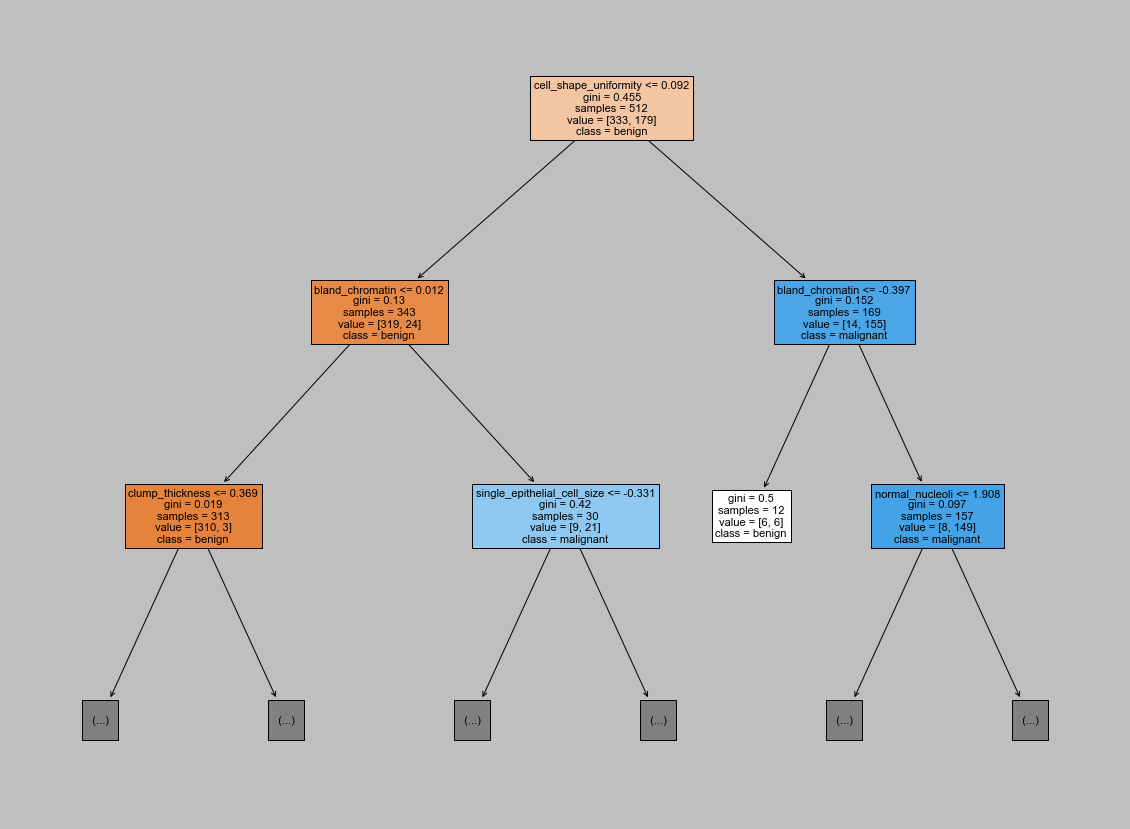

In [404]:
plt.figure(figsize=(20,15))
plt.style.use('grayscale')

plot_tree(tuner_dtc.best_estimator_,
          feature_names = X_train.columns, 
          class_names = ['benign', 'malignant'],
          filled = True, max_depth = 2)

plt.show()

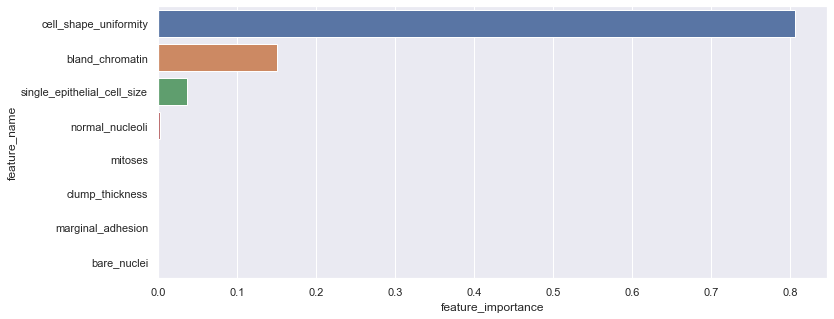

In [407]:
feature_importances = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(tuner_dtc.best_estimator_.feature_importances_)], 1)
feature_importances.columns = ['feature_name', 'feature_importance']
feature_importances = feature_importances.sort_values('feature_importance', ascending = False)

plt.figure(figsize = (12,5))
sns.barplot(y = feature_importances['feature_name'], x = feature_importances['feature_importance'])
plt.show()

In [408]:
print('Accuracy on test set: ', round(accuracy_score(y_test, tuner_dtc.best_estimator_.predict(X_test_scaled)), 3))
print('AUC on test set: ', round(roc_auc_score(y_test, tuner_dtc.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3))
print('\n')
print(classification_report(y_test, tuner_dtc.best_estimator_.predict(X_test_scaled)))

Accuracy on test set:  0.93
AUC on test set:  0.975


              precision    recall  f1-score   support

           0       0.94      0.95      0.95       111
           1       0.91      0.88      0.90        60

    accuracy                           0.93       171
   macro avg       0.93      0.92      0.92       171
weighted avg       0.93      0.93      0.93       171



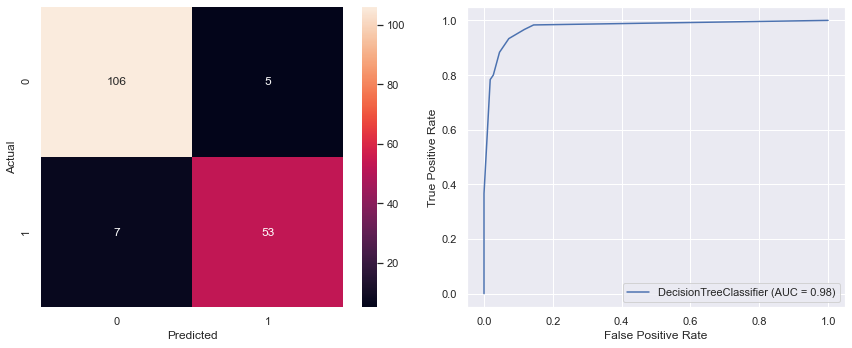

In [409]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

confusion_matrix = pd.crosstab(y_test, tuner_dtc.best_estimator_.predict(X_test_scaled), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0])

plot_roc_curve(tuner_dtc.best_estimator_, X_test_scaled, y_test, ax = axs[1])

fig.tight_layout()
plt.show()

## Compare Accuracy, AUC scores of models, cutoff values and accuracies @ cutoff

##### Find optimal threshold to avoid False Negatives (predicted healthy, actually sick)

In [250]:
def Find_Optimal_Cutoff(estimator, true_values, predict_on, goal = 'fpr'):
    """
    Find the optimal threshold for minimizing FPR, FNR or making mistakes 'evenly' on the True and False sides
    
    Goal: set to 'fpr' to minimize fpr, 'fnr' to minimize fnr, 'equal' to find the threshold at which the fpr and fnr are closest to each other
    """

    thresholds = []
    fpr = []
    fnr = []

    for i in np.arange(0, 1, 0.01):

        threshold = i
        predicted_probabilities = estimator.predict_proba(predict_on)[:,1]
        predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)

        cm = confusion_matrix(true_values, predicted_classes)

        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        # False positive rate
        FPR = FP/(FP+TN)

        # False negative rate
        FNR = FN/(TP+FN)

        thresholds.append(i)
        fpr.append(FPR[1])
        fnr.append(FNR[1])

    false_rates = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr, 'fnr': fnr})
    false_rates['fpr-fnr'] = abs(false_rates['fpr'] - false_rates['fnr'])
    
    if goal == 'fpr':
        threshold = float(false_rates[false_rates['fpr'] > 0].sort_values('fpr').sort_values('thresholds', ascending = False)[:1]['thresholds'].values) + 0.01
    elif goal == 'fnr':
        threshold = float(false_rates[false_rates['fnr'] > 0].sort_values('fnr').sort_values('thresholds')[:1]['thresholds'].values) - 0.01
    elif goal == 'equal':
        threshold = float(np.mean(false_rates[false_rates['fpr-fnr'] == min(false_rates['fpr-fnr'])]['thresholds']))
        
    predicted_probabilities = estimator.predict_proba(predict_on)[:,1]
    predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)

    acc_at_cutoff = accuracy_score(true_values, predicted_classes)
        
    return false_rates, round(threshold, 3), round(acc_at_cutoff, 3)


def Plot_FNR_FPR(data):
    
    plt.figure(figsize = (8, 5))
    
    sns.lineplot(thresholds, fpr, data = data)
    sns.lineplot(thresholds, fnr, data = data).set_title('FPR and FNR values by threshold')

    plt.xticks(np.arange(0, 1, 0.1))
    plt.legend(['FPR', 'FNR'])
    plt.show()

In [410]:
from sklearn.metrics import confusion_matrix

false_rates_logit, threshold_logit, acc_at_cutoff_logit = Find_Optimal_Cutoff(logit, y_test, X_test_scaled, goal = 'fnr')
false_rates_rf, threshold_rf, acc_at_cutoff_rf = Find_Optimal_Cutoff(tuner.best_estimator_, y_test, X_test_scaled, goal = 'fnr')
false_rates_gbm, threshold_gbm, acc_at_cutoff_gbm = Find_Optimal_Cutoff(tuner_gbm.best_estimator_, y_test, X_test_scaled, goal = 'fnr')
false_rates_svc, threshold_svc, acc_at_cutoff_svc = Find_Optimal_Cutoff(tuner_svc.best_estimator_, y_test, X_test_scaled, goal = 'fnr')
false_rates_knn, threshold_knn, acc_at_cutoff_knn = Find_Optimal_Cutoff(tuner_knn.best_estimator_, y_test, X_test_scaled, goal = 'fnr')
false_rates_rnn, threshold_rnn, acc_at_cutoff_rnn = Find_Optimal_Cutoff(tuner_rnn.best_estimator_, y_test, X_test_scaled, goal = 'fnr')
false_rates_ada, threshold_ada, acc_at_cutoff_ada = Find_Optimal_Cutoff(tuner_ada.best_estimator_, y_test, X_test_scaled, goal = 'fnr')
false_rates_dtc, threshold_dtc, acc_at_cutoff_dtc = Find_Optimal_Cutoff(tuner_dtc.best_estimator_, y_test, X_test_scaled, goal = 'fnr')


logistic_regression = ['Logistic regression', 
                       round(accuracy_score(y_test, logit.predict(X_test_scaled)), 3), 
                       round(roc_auc_score(y_test, logit.predict_proba(X_test_scaled)[:,1]), 3),
                       threshold_logit, 
                       acc_at_cutoff_logit]

random_forest = ['Random forest', 
                  round(accuracy_score(y_test, tuner.best_estimator_.predict(X_test_scaled)), 3), 
                  round(roc_auc_score(y_test, tuner.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3),
                  threshold_rf, 
                  acc_at_cutoff_rf]

gradient_boosting_machine = ['Gradient Boosting Machine', 
                              round(accuracy_score(y_test, tuner_gbm.best_estimator_.predict(X_test_scaled)), 3), 
                              round(roc_auc_score(y_test, tuner_gbm.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3),
                              threshold_gbm, 
                              acc_at_cutoff_gbm]

support_vector_classifier = ['Support Vector Classifier', 
                              round(accuracy_score(y_test, tuner_svc.best_estimator_.predict(X_test_scaled)), 3), 
                              round(roc_auc_score(y_test, tuner_svc.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3),
                              threshold_svc, 
                              acc_at_cutoff_svc]

k_nearest_neighbrs = ['K Nearest Neighbors', 
                       round(accuracy_score(y_test, tuner_knn.best_estimator_.predict(X_test_scaled)), 3), 
                       round(roc_auc_score(y_test, tuner_knn.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3),
                       threshold_knn, 
                       acc_at_cutoff_knn]

r_nearest_neighbrs = ['Radius Nearest Neighbors', 
                       round(accuracy_score(y_test, tuner_rnn.best_estimator_.predict(X_test_scaled)), 3), 
                       round(roc_auc_score(y_test, tuner_rnn.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3),
                       threshold_rnn, 
                       acc_at_cutoff_rnn]

adaboost_classifier = ['AdaBoost Classifier', 
                       round(accuracy_score(y_test, tuner_ada.best_estimator_.predict(X_test_scaled)), 3), 
                       round(roc_auc_score(y_test, tuner_ada.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3),
                       threshold_ada, 
                       acc_at_cutoff_ada]

decision_tree_classifier = ['Decision Tree Classifier', 
                             round(accuracy_score(y_test, tuner_dtc.best_estimator_.predict(X_test_scaled)), 3), 
                             round(roc_auc_score(y_test, tuner_dtc.best_estimator_.predict_proba(X_test_scaled)[:,1]), 3),
                             threshold_dtc, 
                             acc_at_cutoff_dtc]

results = pd.DataFrame([logistic_regression, 
                        random_forest,
                        gradient_boosting_machine,
                        support_vector_classifier, 
                        k_nearest_neighbrs,
                        r_nearest_neighbrs, 
                        adaboost_classifier,
                        decision_tree_classifier], 
                       columns = ['Model', 'Accuracy @ 50%', 'AUC', 'Cutoff for minimal FNR', 'Accuracy @ CutOff'])
results

,Model,Accuracy @ 50%,AUC,Cutoff for minimal FNR,Accuracy @ CutOff
0,Logistic regression,0.965,0.996,0.06,0.971
1,Random forest,0.971,0.995,0.45,0.977
2,Gradient Boosting Machine,0.959,0.995,0.41,0.977
3,Support Vector Classifier,0.942,0.997,0.11,0.953
4,K Nearest Neighbors,0.953,0.994,0.14,0.959
5,Radius Nearest Neighbors,0.930,0.996,0.14,0.977
6,AdaBoost Classifier,0.959,0.996,0.36,0.971
7,Decision Tree Classifier,0.930,0.975,0.00,0.351


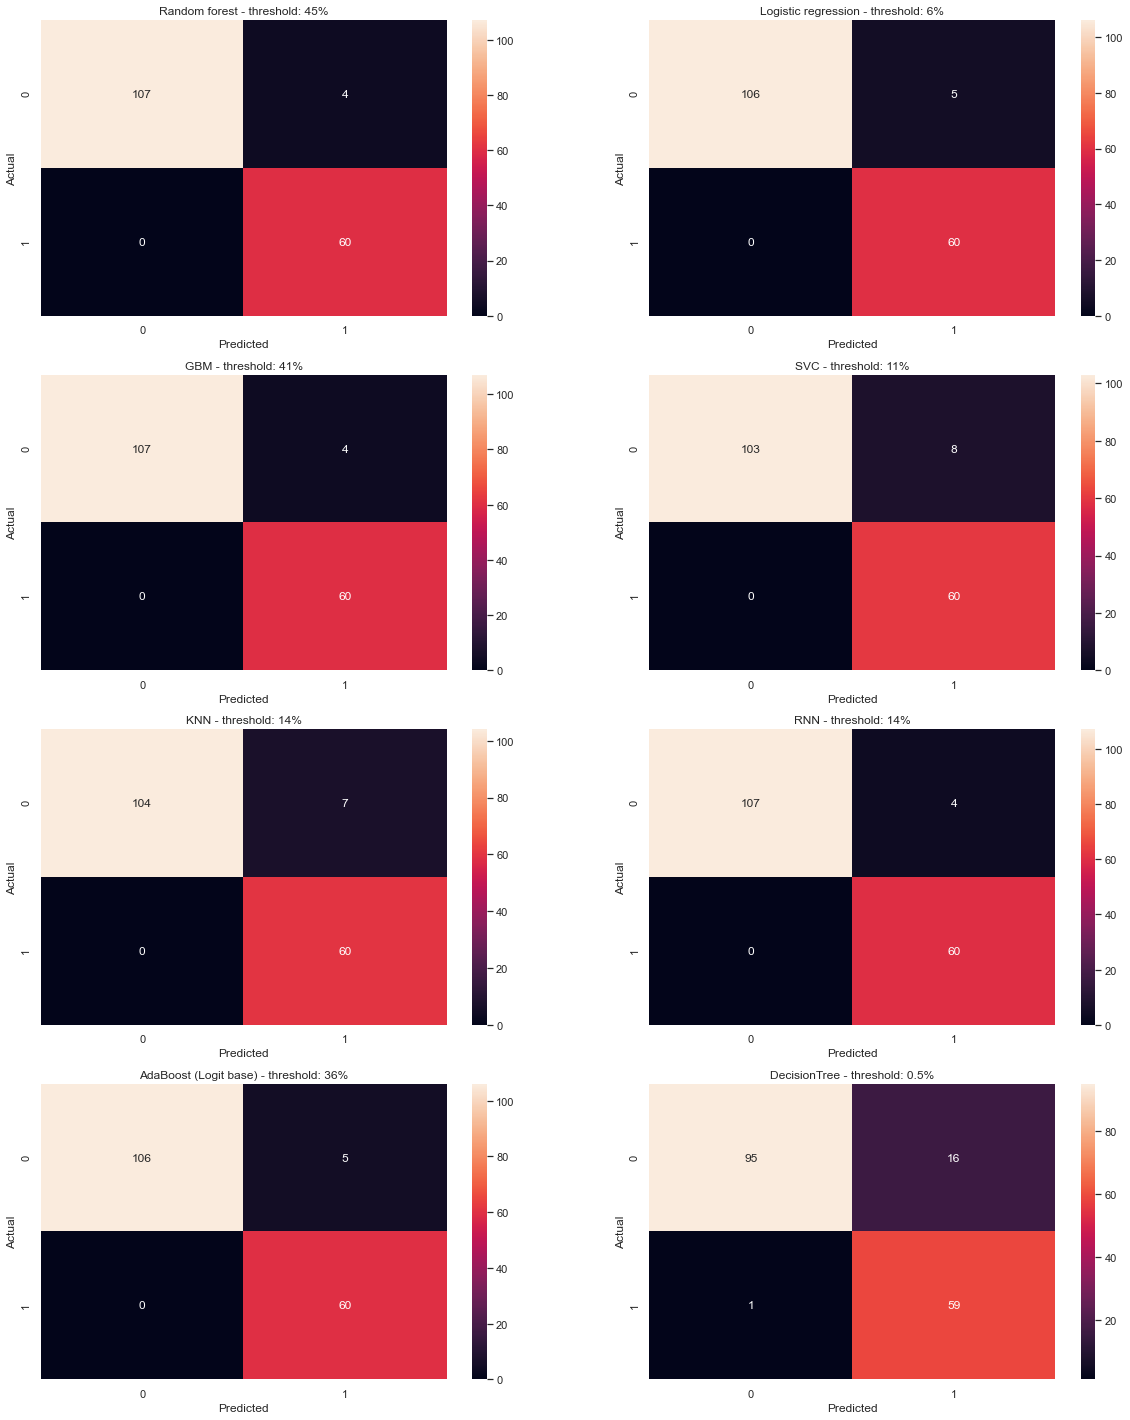

In [418]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize=(20, 25))

threshold = 0.45
predicted_probabilities = tuner.best_estimator_.predict_proba(X_test_scaled)[:,1]
predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)
confusion_matrix = pd.crosstab(y_test, predicted_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0, 0]).set_title('Random forest - threshold: 45%')

threshold = 0.06
predicted_probabilities = logit.predict_proba(X_test_scaled)[:,1]
predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)
confusion_matrix = pd.crosstab(y_test, predicted_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[0, 1]).set_title('Logistic regression - threshold: 6%')

threshold = 0.41
predicted_probabilities = tuner_gbm.predict_proba(X_test_scaled)[:,1]
predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)
confusion_matrix = pd.crosstab(y_test, predicted_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[1, 0]).set_title('GBM - threshold: 41%')

threshold = 0.11
predicted_probabilities = tuner_svc.predict_proba(X_test_scaled)[:,1]
predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)
confusion_matrix = pd.crosstab(y_test, predicted_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[1, 1]).set_title('SVC - threshold: 11%')

threshold = 0.14
predicted_probabilities = tuner_knn.predict_proba(X_test_scaled)[:,1]
predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)
confusion_matrix = pd.crosstab(y_test, predicted_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[2, 0]).set_title('KNN - threshold: 14%')

threshold = 0.14
predicted_probabilities = tuner_rnn.predict_proba(X_test_scaled)[:,1]
predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)
confusion_matrix = pd.crosstab(y_test, predicted_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[2, 1]).set_title('RNN - threshold: 14%')

threshold = 0.36
predicted_probabilities = tuner_ada.predict_proba(X_test_scaled)[:,1]
predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)
confusion_matrix = pd.crosstab(y_test, predicted_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[3, 0]).set_title('AdaBoost (Logit base) - threshold: 36%')

threshold = 0.005
predicted_probabilities = tuner_dtc.predict_proba(X_test_scaled)[:,1]
predicted_classes = np.where(predicted_probabilities > threshold, 1, 0)
confusion_matrix = pd.crosstab(y_test, predicted_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot = True, cmap = None, fmt='.0f', ax = axs[3, 1]).set_title('DecisionTree - threshold: 0.5%')

plt.show()